# Notebook 3-2
# Models ensembling, evaluation

* Objective of this notebook is:
* Get best model available with 38 predictive features, that we found out significant to target variable, by eliminating faetures that had least significance by Light gradient boosting model shap values (Feature importance)

In [1]:
from pycaret.classification import *
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np
from feature_engine.selection import RecursiveFeatureAddition
import shap
from collections import Counter
import warnings
import scipy
import sklearn
from sklearn.model_selection import KFold,cross_val_predict, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, average_precision_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
import shap
import joblib
from sklearn.impute import SimpleImputer
from sklearn import metrics
from scipy.stats import mannwhitneyu, chi2_contingency
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold,KFold
import lightgbm
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from IPython.display import display, IFrame,Image
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt
import seaborn as sns
import analysis_functions
from IPython.display import display, IFrame
from sklearn.metrics import (
    auc,
    roc_auc_score,
    roc_curve,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    balanced_accuracy_score,
    f1_score,
)
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


%matplotlib inline

In [2]:
df_modeling = pd.read_csv("prepared_data/post_modelling_data.csv")
df_modeling

,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_BIRTH,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT_W_CITY,...,NAME_CONTRACT_STATUS_Refused_count_HCredit_PApp,NAME_GOODS_CATEGORY_Other_count_HCredit_PApp,NAME_PORTFOLIO_Cash_count_HCredit_PApp,NAME_PRODUCT_TYPE_walk-in_count_HCredit_PApp,NAME_SELLER_INDUSTRY_Other_count_HCredit_PApp,NAME_YIELD_GROUP_high_count_HCredit_PApp,NAME_YIELD_GROUP_low_action_count_HCredit_PApp,AMT_CREDIT_HCredit_PApp,SELLERPLACE_AREA_HCredit_PApp,TARGET
0,100002,202500.0,406597.5,0.018801,-3648.0,-9461,-2120,0,1,2,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,179055.00,500.000000,1
1,100003,270000.0,1293502.5,0.003541,-1186.0,-16765,-291,0,1,1,...,0.0,2.0,1.0,0.0,1.0,0.0,0.0,484191.00,533.000000,0
2,100004,67500.0,135000.0,0.010032,-4260.0,-19046,-2531,1,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20106.00,30.000000,0
3,100006,135000.0,312682.5,0.008019,-9833.0,-19005,-2437,0,0,2,...,1.0,2.0,3.0,0.0,1.0,2.0,0.0,291695.50,894.222222,0
4,100007,121500.0,513000.0,0.028663,-4311.0,-19932,-3458,0,0,2,...,0.0,2.0,4.0,1.0,0.0,3.0,0.0,166638.75,409.166667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,157500.0,254700.0,0.032561,-8456.0,-9327,-1982,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,40455.00,30.000000,0
307507,456252,72000.0,269550.0,0.025164,-4388.0,-20775,-4090,0,1,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,56821.50,190.000000,0
307508,456253,153000.0,677664.0,0.005002,-6737.0,-14966,-5150,0,0,3,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,20625.75,22.000000,0
307509,456254,171000.0,370107.0,0.005313,-2562.0,-11961,-931,0,0,2,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,134439.75,1578.000000,1


In [18]:
mean_credit_target_1 = df_modeling.loc[df_modeling['TARGET'] == 1, 'AMT_CREDIT'].mean()
print(f"The mean AMT_CREDIT for records with TARGET=1 is: {mean_credit_target_1}")

The mean AMT_CREDIT for records with TARGET=1 is: 557778.527673716


In [3]:
df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 40 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   SK_ID_CURR                                        307511 non-null  int64  
 1   AMT_INCOME_TOTAL                                  307511 non-null  float64
 2   AMT_CREDIT                                        307511 non-null  float64
 3   REGION_POPULATION_RELATIVE                        307511 non-null  float64
 4   DAYS_REGISTRATION                                 307511 non-null  float64
 5   DAYS_BIRTH                                        307511 non-null  int64  
 6   DAYS_ID_PUBLISH                                   307511 non-null  int64  
 7   FLAG_WORK_PHONE                                   307511 non-null  int64  
 8   FLAG_PHONE                                        307511 non-null  int64  
 9   REGI

In [4]:
df_modeling.isna().any()

SK_ID_CURR                                          False
AMT_INCOME_TOTAL                                    False
AMT_CREDIT                                          False
REGION_POPULATION_RELATIVE                          False
DAYS_REGISTRATION                                   False
DAYS_BIRTH                                          False
DAYS_ID_PUBLISH                                     False
FLAG_WORK_PHONE                                     False
FLAG_PHONE                                          False
REGION_RATING_CLIENT_W_CITY                         False
REG_CITY_NOT_WORK_CITY                              False
FLAG_DOCUMENT_3                                     False
NAME_CONTRACT_TYPE                                  False
CODE_GENDER                                         False
FLAG_OWN_CAR                                        False
NAME_INCOME_TYPE                                    False
NAME_EDUCATION_TYPE                                 False
NAME_FAMILY_ST

In [3]:
df_modeling.rename(columns={'NAME_PRODUCT_TYPE_walk-in_count_HCredit_PApp': 'NAME_PRODUCT_TYPE_walk_in_count_HCredit_PApp'}, inplace=True)

In [117]:
classification_setup = setup(
    df_modeling,
    target="TARGET",
    normalize=True, 
    normalize_method='zscore',
    transformation=True,
    train_size = 0.9,
    session_id=42,
    fix_imbalance=True,
    fix_imbalance_method='randomundersampler'
    
)

,Description,Value
0,Session id,42
1,Target,TARGET
2,Target type,Binary
3,Original data shape,"(307511, 40)"
4,Transformed data shape,"(75436, 58)"
5,Transformed train set shape,"(44684, 58)"
6,Transformed test set shape,"(30752, 58)"
7,Ordinal features,1
8,Numeric features,32
9,Categorical features,7


In [119]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.9193,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0310
catboost,CatBoost Classifier,0.6644,0.7206,0.6565,0.1469,0.2400,0.1245,0.1824,20.5870
gbc,Gradient Boosting Classifier,0.6589,0.7153,0.6557,0.1445,0.2369,0.1205,0.1781,14.6690
rf,Random Forest Classifier,0.6579,0.7026,0.6379,0.1413,0.2314,0.1143,0.1684,9.1960
lightgbm,Light Gradient Boosting Machine,0.6567,0.7175,0.6626,0.1447,0.2376,0.1211,0.1799,3.8320
ada,Ada Boost Classifier,0.6510,0.7035,0.6452,0.1399,0.2299,0.1121,0.1672,5.8360
xgboost,Extreme Gradient Boosting,0.6473,0.7025,0.6469,0.1387,0.2285,0.1102,0.1655,3.9100
lr,Logistic Regression,0.6467,0.7031,0.6520,0.1393,0.2296,0.1114,0.1676,6.5870
ridge,Ridge Classifier,0.6460,0.0000,0.6532,0.1392,0.2295,0.1113,0.1677,2.8360
lda,Linear Discriminant Analysis,0.6460,0.7031,0.6532,0.1392,0.2295,0.1113,0.1677,3.1190


* Dummy Classifier has best Accuracy : 0.9193 .We dont look at accuraccy and almost all other metrics are 0
* CatBoost Classifier highest AUC : 0.7206 but it takes much longer to train and it's much biger incomparison with Light Gradient  Boosting Classifier.
* Naive Bayes Classifier has best Recall : 0.8936
* Light Gradient  Boosting Classifier 

In [3]:
categorical_features = df_modeling.select_dtypes(include=['object']).columns
numerical_features = df_modeling.select_dtypes(include= 'number').columns
df_modeling[categorical_features] = df_modeling[categorical_features].astype('category')

In [4]:
np.int = int
np.float = float
np.bool = bool

In [5]:
feat_to_drop=['TARGET','SK_ID_CURR']

In [6]:
X = df_modeling.drop(columns=feat_to_drop,axis=1)
y = df_modeling['TARGET']

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3,stratify=y, random_state=42)

## Hyper parameters tuning for XGBOOST and LGBM models

In [74]:
xgb_param_grid = {
    'boosting_type': ['gbtree', 'gblinear', 'dart'],
    'learning_rate': (0.01, 0.1),  
    'n_estimators': (150, 900),
    'max_depth': (5, 11),
    'scale_pos_weight': (11,),
    'reg_lambda': (0.5, 10),
    'num_leaves': (30,1200)
}

xgb_model = XGBClassifier(enable_categorical=True)

xgb_bayes_search = BayesSearchCV(xgb_model, xgb_param_grid, n_iter=75, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)
xgb_bayes_search.fit(X_train, y_train)

print("\nBest Hyperparameters for XGBClassifier:")
print(xgb_bayes_search.best_params_)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [75]:
xgb_bparams = xgb_bayes_search.best_params_

In [76]:
lgbm_param_grid = {
    'learning_rate': (0.01, 0.1),
    'n_estimators': (150, 900),
    'max_depth': (5, 11),
    'num_leaves': (30,1200),
    'scale_pos_weight': (11,),
    'reg_lambda': (0.5, 5),
    "bagging_freq": (5, 20),
    "bagging_fraction": (0.7, 0.9)
}

lgbm_model = LGBMClassifier()
lgbm_bayes_search = BayesSearchCV(lgbm_model, lgbm_param_grid, n_iter=75, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)
lgbm_bayes_search.fit(X_train, y_train)

print("Best Hyperparameters for LGBMClassifier:")
print(lgbm_bayes_search.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [77]:
Lgbm_bparams = lgbm_bayes_search.best_params_

In [78]:
print("Best Hyperparameters for LGBMClassifier:")
print(lgbm_bayes_search.best_params_)

Best Hyperparameters for LGBMClassifier:
OrderedDict([('bagging_fraction', 0.7384154063844491), ('bagging_freq', 5), ('learning_rate', 0.01), ('max_depth', 11), ('n_estimators', 900), ('num_leaves', 30), ('reg_lambda', 5.0), ('scale_pos_weight', 11)])


In [133]:
numeric_transformer_log = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer_log = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

class_weights = {0: 1, 1: 11}
preprocessor_log = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_log, numerical_features),
        ('cat', categorical_transformer_log, categorical_features)
    ])

pipeline_log = Pipeline(steps=[('preprocessor', preprocessor_log),
                             ('classifier', LogisticRegression(class_weight=class_weights))])

###  evaluating XGB , LGBM and soft vote ensemled models 

In [138]:
n_splits = 5
random_state = 22
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

models = [
    LGBMClassifier(
       **Lgbm_bparams
    ),
    XGBClassifier(
        **xgb_bparams, enable_categorical=True
    ),
    pipeline_log
]

soft_voting_classifier = VotingClassifier(
    estimators=[
        ('lgbm', LGBMClassifier(
            **Lgbm_bparams
        )),
        ('xgb', XGBClassifier(
            **xgb_bparams, enable_categorical=True
        )),
    ],
    voting='soft'
)
soft_voting_classifier_log = VotingClassifier(
    estimators=[
        ('lgbm', LGBMClassifier(
            **Lgbm_bparams
        )),
        ('log', pipeline_log),
    ],
    voting='soft'
)

classifiers = [
    "LGB",
    "XGB",
    "Logistic Regression",
    "SOFTVOTE",
    "LogR_LGBM_SVOTE"
]

recall_macro_scores = []  
auc_pr_scores = []  

for model, classifier_name in zip(models + [soft_voting_classifier ,soft_voting_classifier_log], classifiers):
    cv_result_auc_pr = cross_val_score(model, X, y, cv=kfold, scoring="roc_auc")
    auc_pr_scores.append(cv_result_auc_pr.mean())

    recall_macro_scores_list = []
    auc_pr_scores_list = []
    
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        recall_macro_scores_list.append(recall_score(y_test, (y_pred_proba > 0.5).astype(int), average='macro'))
        auc_pr_scores_list.append(roc_auc_score(y_test, y_pred_proba, average='weighted'))

    recall_macro_scores.append(np.mean(recall_macro_scores_list))

new_models_dataframe2 = pd.DataFrame(
    {"CV Recall Macro Mean": recall_macro_scores, "Recall Macro Mean": recall_macro_scores,
     "CV AUC-PR Mean": auc_pr_scores, "AUC-PR Mean": auc_pr_scores}, index=classifiers
)
new_models_dataframe2

[LightGBM] [Warning] bagging_fraction is set=0.7384154063844491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384154063844491
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7384154063844491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384154063844491
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 15934, number of negative: 180873
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3867
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080963 -> initscore=-2.429340
[LightGBM] [Info] Start training from score -2.4

[LightGBM] [Warning] bagging_fraction is set=0.7384154063844491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384154063844491
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7384154063844491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384154063844491
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7384154063844491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384154063844491
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 15918, number of negative: 180889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034203 seconds.
You can set `force_row_wise=true` to remove the overhead.
A

[LightGBM] [Warning] bagging_fraction is set=0.7384154063844491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384154063844491
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 15941, number of negative: 180866
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3859
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080998 -> initscore=-2.428862
[LightGBM] [Info] Start training from score -2.428862
[LightGBM] [Warning] bagging_fraction is set=0.7384154063844491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384154063844491
[LightGBM] [Warning] bagging_freq is s

[LightGBM] [Warning] bagging_fraction is set=0.7384154063844491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384154063844491
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7384154063844491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384154063844491
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7384154063844491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384154063844491
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 15934, number of negative: 180873
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035239 seconds.
You can set `force_row_wise=true` to remove the overhead.
A

[LightGBM] [Warning] bagging_fraction is set=0.7384154063844491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384154063844491
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 15844, number of negative: 180963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3861
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080505 -> initscore=-2.435502
[LightGBM] [Info] Start training from score -2.435502
[LightGBM] [Warning] bagging_fraction is set=0.7384154063844491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384154063844491
[LightGBM] [Warning] bagging_freq is s

,CV Recall Macro Mean,Recall Macro Mean,CV AUC-PR Mean,AUC-PR Mean
LGB,0.664157,0.664157,0.724233,0.724233
XGB,0.661644,0.661644,0.722729,0.722729
Logistic Regression,0.627028,0.627028,0.675032,0.675032
SOFTVOTE,0.663077,0.663077,0.724458,0.724458
LogR_LGBM_SVOTE,0.657228,0.657228,0.714754,0.714754


## Models stacking.
* Creation of Logistic regrssion model and use of it's predictions as an extra feature
* Creation of LGBM Classifier for final data fitting

Stacking LGBM Classifier with Logistic regrssion , because Logistic regrssion models does diferent operations ,calculations than gradient Boosting models

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      0.65      0.77    226133
           1       0.13      0.60      0.22     19876

    accuracy                           0.65    246009
   macro avg       0.54      0.63      0.49    246009
weighted avg       0.88      0.65      0.73    246009

Confusion Matrix for Logistic Regression:
[[147138  78995]
 [  7883  11993]]


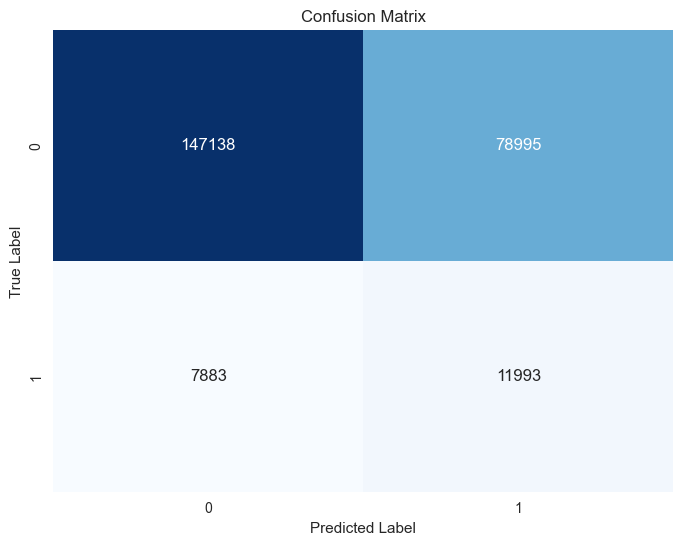

In [156]:

Log_predictions = cross_val_predict(pipeline_log, X, y, cv=kfold)


X_with_log_preds = pd.concat([X, pd.Series(Log_predictions, name='log_preds')], axis=1)
print("Classification Report for Logistic Regression:")
print(classification_report(y, Log_predictions))

print("Confusion Matrix for Logistic Regression:")
print(confusion_matrix(y, Log_predictions))
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y, Log_predictions), annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [157]:
X_with_log_preds = pd.concat([X, pd.Series(Log_predictions, name='xgb_preds')], axis=1)

In [158]:
X_with_log_preds

,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_BIRTH,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_WORK_CITY,...,NAME_CONTRACT_STATUS_Refused_count_HCredit_PApp,NAME_GOODS_CATEGORY_Other_count_HCredit_PApp,NAME_PORTFOLIO_Cash_count_HCredit_PApp,NAME_PRODUCT_TYPE_walk-in_count_HCredit_PApp,NAME_SELLER_INDUSTRY_Other_count_HCredit_PApp,NAME_YIELD_GROUP_high_count_HCredit_PApp,NAME_YIELD_GROUP_low_action_count_HCredit_PApp,AMT_CREDIT_HCredit_PApp,SELLERPLACE_AREA_HCredit_PApp,xgb_preds
0,270000.0,1293502.5,0.003541,-1186.0,-16765,-291,0,1,1,0,...,0.0,2.0,1.0,0.0,1.0,0.0,0.0,484191.00,533.000000,0
1,135000.0,312682.5,0.008019,-9833.0,-19005,-2437,0,0,2,0,...,1.0,2.0,3.0,0.0,1.0,2.0,0.0,291695.50,894.222222,0
2,121500.0,513000.0,0.028663,-4311.0,-19932,-3458,0,0,2,1,...,0.0,2.0,4.0,1.0,0.0,3.0,0.0,166638.75,409.166667,0
3,99000.0,490495.5,0.035792,-4970.0,-16941,-477,1,1,2,0,...,0.0,2.0,1.0,0.0,0.0,0.0,0.0,162767.70,73.000000,0
4,360000.0,1530000.0,0.003122,-4597.0,-18850,-2379,1,0,3,1,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,260811.00,8636.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246004,157500.0,254700.0,0.032561,-8456.0,-9327,-1982,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,40455.00,30.000000,0
246005,72000.0,269550.0,0.025164,-4388.0,-20775,-4090,0,1,2,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,56821.50,190.000000,0
246006,153000.0,677664.0,0.005002,-6737.0,-14966,-5150,0,0,3,1,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,20625.75,22.000000,1
246007,171000.0,370107.0,0.005313,-2562.0,-11961,-931,0,0,2,1,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,134439.75,1578.000000,1


In [145]:
lgb_model = LGBMClassifier(scale_pos_weight = 11)
lgb_predictions = cross_val_predict(lgb_model, X_with_log_preds, y, cv=kfold,verbose=0)

roc_auc = roc_auc_score(y, lgb_predictions)
print(f"ROC-AUC Score for LGBM: {roc_auc}")

[LightGBM] [Info] Number of positive: 15934, number of negative: 180873
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3869
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080963 -> initscore=-2.429340
[LightGBM] [Info] Start training from score -2.429340
[LightGBM] [Info] Number of positive: 15844, number of negative: 180963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3863
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 39
[LightGBM] [In

In [102]:
xgb_model = XGBClassifier(**xgb_bparams, enable_categorical=True)
xgb_predictions = cross_val_predict(xgb_model, X, y, cv=kfold)

X_with_xgb_preds = pd.concat([X, pd.Series(xgb_predictions, name='xgb_preds')], axis=1)

lgb_model = LGBMClassifier(**Lgbm_bparams)
lgb_predictions = cross_val_predict(lgb_model, X_with_xgb_preds, y, cv=kfold)

roc_auc = roc_auc_score(y, lgb_predictions)
print(f"ROC-AUC Score for LGBM: {roc_auc}")

print("Classification Report for XGBoost:")
print(classification_report(y, xgb_predictions))

print("Confusion Matrix for XGBoost:")
print(confusion_matrix(y, xgb_predictions))

print("Classification Report for LightGBM:")
print(classification_report(y, lgb_predictions))

print("Confusion Matrix for LightGBM:")
print(confusion_matrix(y, lgb_predictions))

[LightGBM] [Warning] bagging_fraction is set=0.7384154063844491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384154063844491
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7384154063844491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384154063844491
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 15934, number of negative: 180873
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3869
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080963 -> init

In [180]:
print("Classification Report for XGBoost:")
classification_report(y, xgb_predictions)

print("Confusion Matrix for XGBoost:")
print(confusion_matrix(y, xgb_predictions))

roc_auc = roc_auc_score(y, lgb_predictions)
print(f"ROC-AUC Score for LGBM: {roc_auc}")

print("Classification Report for LightGBM:")
print(classification_report(y, lgb_predictions))

print("Confusion Matrix for LightGBM:")
print(confusion_matrix(y, lgb_predictions))

Classification Report for XGBoost:
Confusion Matrix for XGBoost:
[[161029  65104]
 [  7727  12149]]
ROC-AUC Score for LGBM: 0.6586490637818857
Classification Report for LightGBM:
              precision    recall  f1-score   support

           0       0.95      0.70      0.81    226133
           1       0.15      0.62      0.25     19876

    accuracy                           0.69    246009
   macro avg       0.55      0.66      0.53    246009
weighted avg       0.89      0.69      0.76    246009

Confusion Matrix for LightGBM:
[[158423  67710]
 [  7618  12258]]


In [91]:
xgb_model = XGBClassifier(**xgb_bparams, enable_categorical=True)
xgb_probabilities = cross_val_predict(xgb_model, X, y, cv=kfold, method='predict_proba')[:, 1]

# Add XGBoost probabilities as an extra feature to the original dataset
X_with_xgb_probs = pd.concat([X, pd.Series(xgb_probabilities, name='xgb_probs')], axis=1)

# Fit LGBM model using cross-validation
lgb_model = LGBMClassifier(**Lgbm_bparams)
lgb_predictions = cross_val_predict(lgb_model, X_with_xgb_probs, y, cv=kfold, method='predict_proba')[:, 1]

# Calculate ROC-AUC score for LGBM predictions
roc_auc = roc_auc_score(y, lgb_predictions)
print(f"ROC-AUC Score for LGBM: {roc_auc}")

[LightGBM] [Warning] bagging_fraction is set=0.7384154063844491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384154063844491
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7384154063844491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384154063844491
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 15934, number of negative: 180873
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.099183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4122
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080963 -> init

In [168]:
roc_auc_xgb = roc_auc_score(y, xgb_probabilities)

In [169]:
roc_auc_lgb = roc_auc_score(y, lgb_predictions)

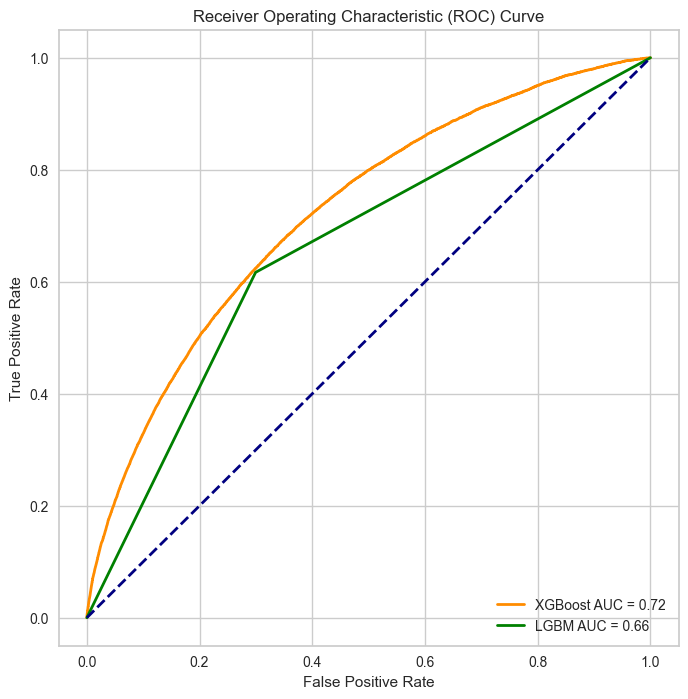

In [172]:
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y, xgb_probabilities)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(y, lgb_predictions)
roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

plt.figure(figsize=(8, 8))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'XGBoost AUC = {roc_auc_xgb:.2f}')
plt.plot(fpr_lgbm, tpr_lgbm, color='green', lw=2, label=f'LGBM AUC = {roc_auc_lgbm:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [8]:
lgb_params_main = {
    'bagging_fraction': 0.7384154063844491,
    'bagging_freq': 5,
    'learning_rate': 0.01,
    'max_depth': 11,
    'n_estimators': 900,
    'num_leaves': 30,
    'reg_lambda': 5.0,
    'scale_pos_weight': 11
}

lgb_model_main = LGBMClassifier(**lgb_params_main)

lgb_model_main.fit(
    X_train, y_train, 
)

  File "C:\Users\artur\anaconda3\envs\Stroke\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Warning] bagging_fraction is set=0.7384154063844491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384154063844491
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7384154063844491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384154063844491
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3868
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080727 -> init

LGBMClassifier(bagging_fraction=0.7384154063844491, bagging_freq=5,
               learning_rate=0.01, max_depth=11, n_estimators=900,
               num_leaves=30, reg_lambda=5.0, scale_pos_weight=11)

[LightGBM] [Warning] bagging_fraction is set=0.7384154063844491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384154063844491
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


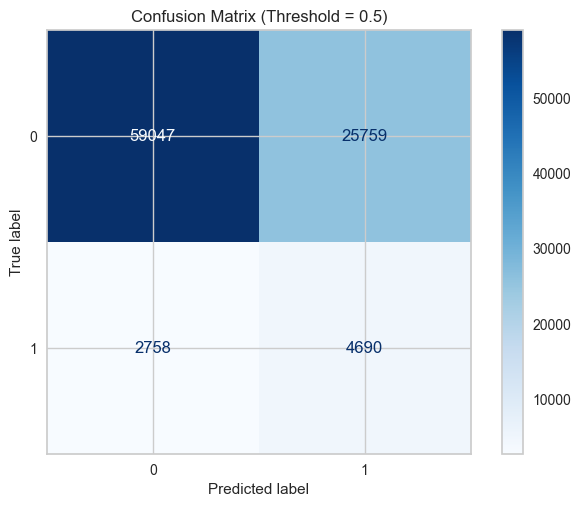

In [9]:
lgb_predictions_proba = lgb_model_main.predict_proba(X_val)[:, 1]

threshold = 0.5

lgb_predictions_binary = (lgb_predictions_proba > threshold).astype(int)

conf_matrix = confusion_matrix(y_val, lgb_predictions_binary)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_val))
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()

In [10]:
class_report = classification_report(y_val, lgb_predictions_binary)
print(class_report)

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     84806
           1       0.15      0.63      0.25      7448

    accuracy                           0.69     92254
   macro avg       0.55      0.66      0.53     92254
weighted avg       0.89      0.69      0.76     92254



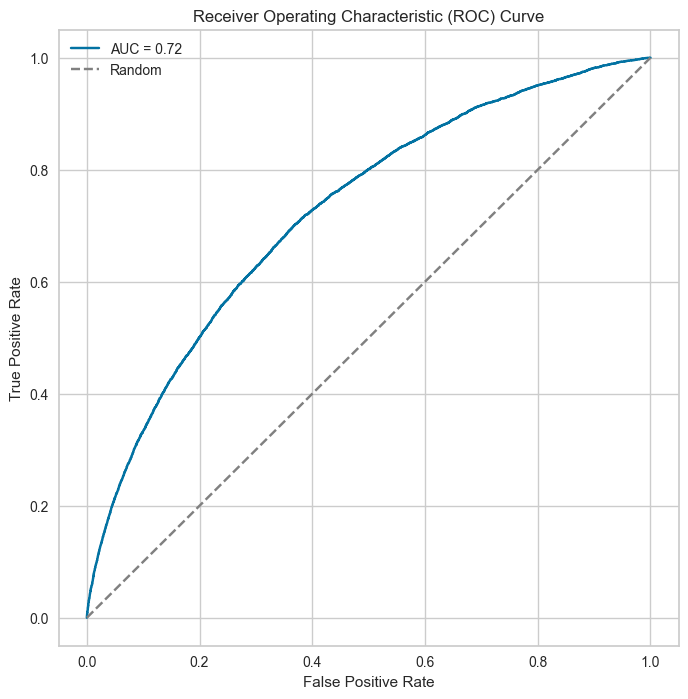

In [11]:
fpr, tpr, thresholds = roc_curve(y_val, lgb_predictions_proba)

roc_auc = roc_auc_score(y_val, lgb_predictions_proba)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


### Models predictions confusion matrix's, when different probability thresholds are set for classification 

[LightGBM] [Warning] bagging_fraction is set=0.7384154063844491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384154063844491
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


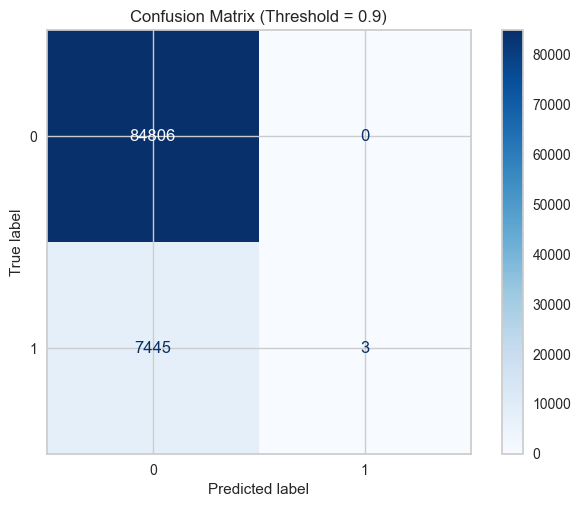

In [17]:
lgb_predictions_proba = lgb_model_main.predict_proba(X_val)[:, 1]

threshold = 0.9

lgb_predictions_binary = (lgb_predictions_proba > threshold).astype(int)

conf_matrix = confusion_matrix(y_val, lgb_predictions_binary)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_val))
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()

Precision with this threshold is 100%, less than 1%


[LightGBM] [Warning] bagging_fraction is set=0.7384154063844491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384154063844491
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


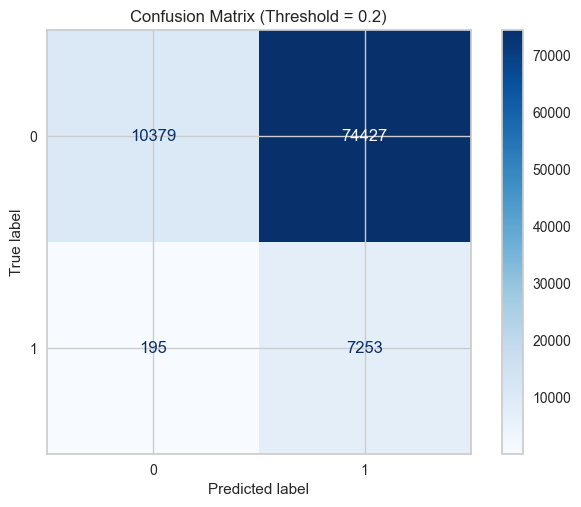

In [19]:
lgb_predictions_proba = lgb_model_main.predict_proba(X_val)[:, 1]

threshold = 0.2

lgb_predictions_binary = (lgb_predictions_proba > threshold).astype(int)

conf_matrix = confusion_matrix(y_val, lgb_predictions_binary)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_val))
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()

With threshold set to 0.2, model captures almost all defaults, but just more than 10% of credits are not indicated as defaults

# Final model feature importance 

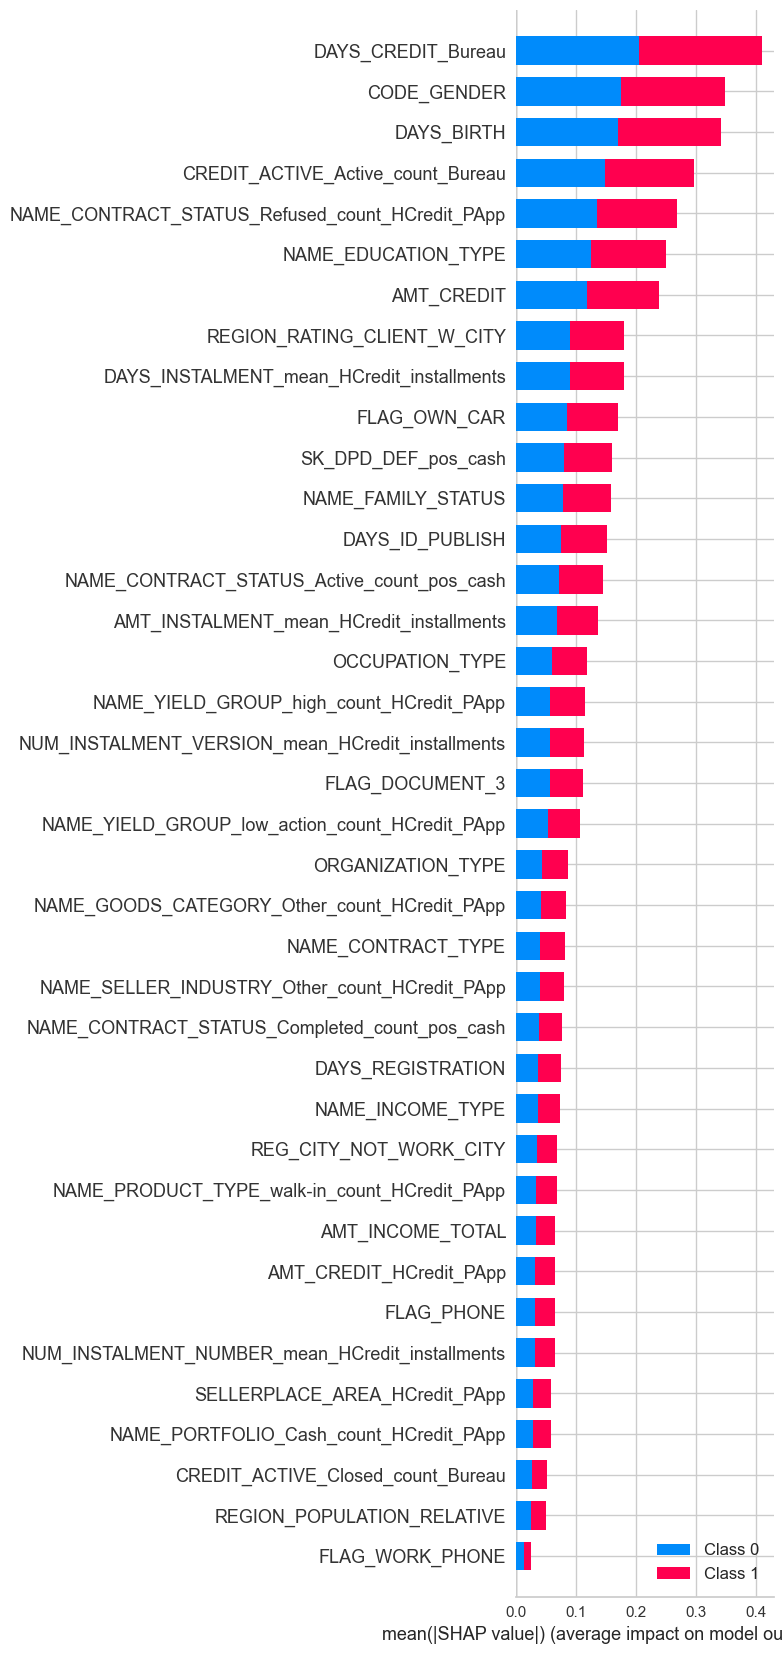

In [15]:
explainer = shap.TreeExplainer(lgb_model_main)

shap_values = explainer.shap_values(X_val)

shap.initjs()
shap.summary_plot(shap_values, X_val, max_display=len(X_val.columns), plot_type='bar')  
plt.show()

Three most influential features for prediction is:
* Days in credit Bureau
* Gender
* Client age

In [24]:
index_to_explain = 4355
class_index = 1

shap_values_instance = shap_values[class_index][index_to_explain, :]

force_plot = shap.force_plot(
    explainer.expected_value[class_index],
    shap_values_instance,
    X_val.iloc[index_to_explain, :],
)

force_plot

* In this example we can see that most influential positive feature at this prediction is Contract type revolving loans and negative is active credit count in Credit bureau, customer has 7 active credits in Credit Bureau
* Model, with 0.5 probability threshold would indicate this credit as not defaulted

In [25]:
index_to_explain = 2
class_index = 1

shap_values_instance = shap_values[class_index][index_to_explain, :]

force_plot = shap.force_plot(
    explainer.expected_value[class_index],
    shap_values_instance,
    X_val.iloc[index_to_explain, :],
)

force_plot

* In this example we can see that most influential positive feature at this prediction is old age and negative is region rating of the client
* Model, with 0.5 probability threshold would indicate this credit as possible default

# Proof of concept (POC)

In [42]:
total_credit_sum = df_modeling['AMT_CREDIT'].sum()

default_sum = df_modeling[df_modeling['TARGET'] == 1]['AMT_CREDIT'].sum()

print(f'From  total of {len(df_modeling)} customers')
print(f"Total amount of credit given is {round(total_credit_sum)}$")
print(f"Total amount of defaulted credit  is {round(default_sum)}$")

From  total of 307511 customers
Total amount of credit given is 184207084196$
Total amount of defaulted credit  is 13846851950$


Our Light gradient boosting classifier, with threshold set at 0.5 can indicate 63% of all defaults

In [37]:
saved_money = round(default_sum*0.63)
saved_money_ratio =  round(saved_money / len(df_modeling))

print(f'Would be saved {saved_money}$ from the beginning ')
print (f'Our model would save {saved_money_ratio}$ per each customer')

Would be saved 8723516728$ from the beginning 
Our model would save 28368$ per each customer


In [43]:
features_with_missing_values = df_modeling.columns[df_modeling.isna().any()].tolist()
print(f"Features that can be missing for prediction, because model have seen missing values during training:")
features_with_missing_values

Features that can be missing for prediction, because model have seen missing values during training:


['CREDIT_ACTIVE_Active_count_Bureau',
 'CREDIT_ACTIVE_Closed_count_Bureau',
 'DAYS_CREDIT_Bureau',
 'AMT_INSTALMENT_mean_HCredit_installments',
 'DAYS_INSTALMENT_mean_HCredit_installments',
 'NUM_INSTALMENT_NUMBER_mean_HCredit_installments',
 'NUM_INSTALMENT_VERSION_mean_HCredit_installments',
 'NAME_CONTRACT_STATUS_Active_count_pos_cash',
 'NAME_CONTRACT_STATUS_Completed_count_pos_cash',
 'SK_DPD_DEF_pos_cash',
 'NAME_CONTRACT_STATUS_Refused_count_HCredit_PApp',
 'NAME_GOODS_CATEGORY_Other_count_HCredit_PApp',
 'NAME_PORTFOLIO_Cash_count_HCredit_PApp',
 'NAME_PRODUCT_TYPE_walk-in_count_HCredit_PApp',
 'NAME_SELLER_INDUSTRY_Other_count_HCredit_PApp',
 'NAME_YIELD_GROUP_high_count_HCredit_PApp',
 'NAME_YIELD_GROUP_low_action_count_HCredit_PApp',
 'AMT_CREDIT_HCredit_PApp',
 'SELLERPLACE_AREA_HCredit_PApp']

In [33]:
model_filename = 'lgb_model_main.joblib'
joblib.dump(lgb_model_main, model_filename)

print(f"Model saved as {model_filename}")

Model saved as lgb_model_main.joblib


# Conclusion 

### Final model information 
* Model: Light Gradient Boosting Classifier
* Hyperparameters:  {
    'bagging_fraction': 0.7384154063844491,
    'bagging_freq': 5,
    'learning_rate': 0.01,
    'max_depth': 11,
    'n_estimators': 900,
    'num_leaves': 30,
    'reg_lambda': 5.0,
    'scale_pos_weight': 11
}
#### Model performance (Evaluation metrics):
* AUC-PR Mean: 0.7242
* Recall weighted average: 0.69
* Precision weighted avg: 0.89
* f1-score weighted avg: 0.76
#### Features used in model prediction:
* Number of features used: 38
* Categorical Features: 
* * ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE',
       'ORGANIZATION_TYPE']
* Numerical Features:
* * [ 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'DAYS_BIRTH',
       'DAYS_ID_PUBLISH','REGION_RATING_CLIENT_W_CITY', 'CREDIT_ACTIVE_Active_count_Bureau',
       'CREDIT_ACTIVE_Closed_count_Bureau', 'DAYS_CREDIT_Bureau',
       'AMT_INSTALMENT_mean_HCredit_installments',
       'DAYS_INSTALMENT_mean_HCredit_installments',
       'NUM_INSTALMENT_NUMBER_mean_HCredit_installments',
       'NUM_INSTALMENT_VERSION_mean_HCredit_installments',
       'NAME_CONTRACT_STATUS_Active_count_pos_cash',
       'NAME_CONTRACT_STATUS_Completed_count_pos_cash', 'SK_DPD_DEF_pos_cash',
       'NAME_CONTRACT_STATUS_Refused_count_HCredit_PApp',
       'NAME_GOODS_CATEGORY_Other_count_HCredit_PApp',
       'NAME_PORTFOLIO_Cash_count_HCredit_PApp',
       'NAME_PRODUCT_TYPE_walk-in_count_HCredit_PApp',
       'NAME_SELLER_INDUSTRY_Other_count_HCredit_PApp',
       'NAME_YIELD_GROUP_high_count_HCredit_PApp',
       'NAME_YIELD_GROUP_low_action_count_HCredit_PApp',
       'AMT_CREDIT_HCredit_PApp', 'SELLERPLACE_AREA_HCredit_PApp']
* Bollean features: 
* * [ FLAG_WORK_PHONE, FLAG_PHONE,'FLAG_DOCUMENT_3', 'FLAG_OWN_CAR', ]    

In [5]:
numerical_features

Index(['SK_ID_CURR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'DAYS_BIRTH',
       'DAYS_ID_PUBLISH', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_WORK_CITY',
       'FLAG_DOCUMENT_3', 'FLAG_OWN_CAR', 'CREDIT_ACTIVE_Active_count_Bureau',
       'CREDIT_ACTIVE_Closed_count_Bureau', 'DAYS_CREDIT_Bureau',
       'AMT_INSTALMENT_mean_HCredit_installments',
       'DAYS_INSTALMENT_mean_HCredit_installments',
       'NUM_INSTALMENT_NUMBER_mean_HCredit_installments',
       'NUM_INSTALMENT_VERSION_mean_HCredit_installments',
       'NAME_CONTRACT_STATUS_Active_count_pos_cash',
       'NAME_CONTRACT_STATUS_Completed_count_pos_cash', 'SK_DPD_DEF_pos_cash',
       'NAME_CONTRACT_STATUS_Refused_count_HCredit_PApp',
       'NAME_GOODS_CATEGORY_Other_count_HCredit_PApp',
       'NAME_PORTFOLIO_Cash_count_HCredit_PApp',
       'NAME_PRODUCT_TYPE_walk-in_count_HCredit_PApp',
       'NAME_SELLER_INDUSTRY_Other_c

* We have found best performing model for credit default risk prediction, it's Light Gradient Boosting Classifier
* If we choose model prediction probability higher than 0.5 as indicator for credit default, than model sucessfully indicates 63% of all defaulted credit loans
* In our data, there is given One hundred eighty-four billion, two hundred seven million dollars and from them there was defaulted Thirteen billion, eight hundred forty-six million dollars.
* Our trained model, potentialy, would save Eight billion, seven hundred twenty-three million dollars in total and Twenty-eight thousand, three hundred sixty-eight dollars per customer.
* For those loans which is our model indicates as defaults, could be set other rules, set higher interest rate or just monitor more actively


### What could be improved:
* Could be looked atthis task differently and split it to different parts.For example different models and analysis could be done on different type of credtis. Because each credit type has it'own unique characteristics, relationships
* During aggregation of tables, from numerical features, could be extracted not only mean of the group, but min, max, mode.
* Try to select most important features, from the begining,with LightGBM model, shap values instead of significance tests
* try to get pairplots of every numerical features, indicate possible clusters of data, and separate clusters using HDBSCAN
* Stack models diferently, use different set of features for all stack models
* Not drop features with high amount of missing values , let handle it LGBM model, or indicate shich records had missing values
* More data could be collected
* More feature engineered, like Dti